### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 3


### Дисциплина: Методы машинного обучения

## Москва 2024
***

##### Студент:  Артамонов Т.Е.
##### Группа:   НКНбд-01-21

Контрольная работа 4 – Вариант 9 
1. Набор данных: diamonds 
2. Независимые признаки: carat, depth 
3. Метка класса: color 
4. Показатель бинарной классификации: 
𝑇𝑃 (True Positives) – число корректно спрогнозированных точек в положительном классе 
5. Параметры нейронных сетей: 
Кол-во скрытых слоев: 4 
Кол-во нейронов в слое: 64 
Оптимизатор: Adamax 
Функции активации в скрытых слоях: leaky_relu, swish, tanh 

### Задание 1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимые признаки и метку класса. Оставьте в наборе признаки, принимающие числовые значения.

### Решение
Импортируем библиотеки

In [1]:
import tensorflow_datasets as tfds
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import math
import pandas as pd

Загрузим датасет

In [2]:
df = tfds.as_dataframe(tfds.load("diamonds", split="train"))
df.tail()

,features/carat,features/clarity,features/color,features/cut,features/depth,features/table,features/x,features/y,features/z,price
53935,1.02,2,4,2,62.900002,59.0,6.38,6.41,4.02,4796.0
53936,0.93,2,4,3,61.799999,59.0,6.27,6.23,3.86,3750.0
53937,0.30,4,5,4,62.400002,54.0,4.30,4.32,2.69,491.0
53938,0.36,3,2,4,61.500000,55.0,4.60,4.57,2.82,807.0
53939,0.70,1,2,2,60.700001,58.0,5.73,5.77,3.49,2195.0


Удалять нечего

### Задание 2. Визуализируйте точки набора данных на плоскости с координатами, соответствующими двум независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

### Решение
Посмотрим какие значения принимает метка

In [3]:
np.unique(df['features/color'])

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Удалим выбросы, чтобы было меньше проблем с обучением в будущем

In [4]:
x_out = df[['features/carat','features/depth']]
df_z = x_out.apply(scipy.stats.zscore)
z_score = 3
df2_out = df[(((df_z >= -z_score).sum(axis=1)==2) & ((df_z <= z_score).sum(axis=1)==2))]
df2_del = pd.concat([df[((df_z < -z_score).sum(axis=1)==1)], df[((df_z > z_score).sum(axis=1)==1)]])
perc = df2_del.shape[0]/x_out.shape[0]*100
print(f'Процент выбросов = {perc}%')


Процент выбросов = 2.028179458657768%


In [5]:
df = df2_out

Выведем точки независимых признаков, меняя цвет в зависимости от класса

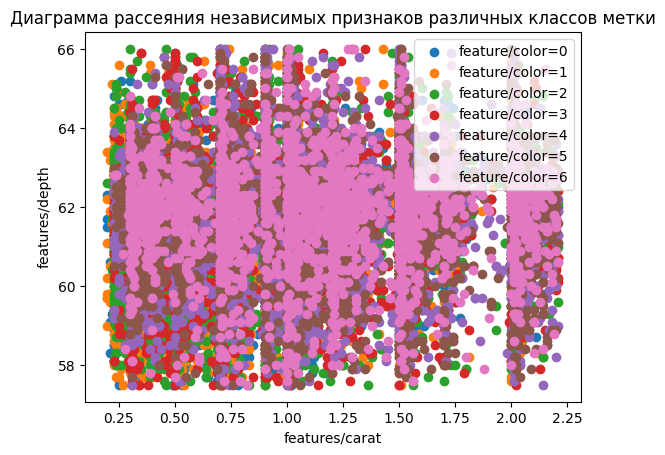

In [6]:
for i in range(7):
    df_tmp = df.loc[df['features/color'] == i]
    plt.scatter(df_tmp['features/carat'], df_tmp['features/depth'],  label='feature/color=' + str(i))
plt.xlabel('features/carat')
plt.ylabel('features/depth')
plt.title('Диаграмма рассеяния независимых признаков различных классов метки')
plt.legend();

### Задание 3. Если признак с метками классов содержит более двух классов, то объедините некоторые классы, чтобы получить набор для бинарной классификации. Объединяйте классы таким образом, чтобы положительный и отрицательный классы были сопоставимы по количеству точек.

### Решение
Посмотрим сколько точек в каждом классе

In [7]:
df['features/color'].value_counts()

features/color
3    11144
1     9673
2     9403
4     8078
0     6705
5     5206
6     2629
Name: count, dtype: int64

Объединим 0 1 2 и 3 4 5 6 классы в новые классы 0 и 1, таким образом достигнем примерного баланса классов

In [8]:
df0 = pd.DataFrame()
df1 = pd.DataFrame()
for i in range(3):
    df_tmp = df.loc[df['features/color'] == i]
    df_tmp['features/color'] = 0
    df0 = pd.concat([df0, df_tmp])
    
for i in range(3, 7):
    df_tmp = df.loc[df['features/color'] == i]
    df_tmp['features/color'] = 1
    df1 = pd.concat([df1, df_tmp])
df_gen = pd.concat([df0, df1])
df_gen

C:\Users\artam\AppData\Local\Temp\ipykernel_11608\136513781.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['features/color'] = 0
C:\Users\artam\AppData\Local\Temp\ipykernel_11608\136513781.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['features/color'] = 1


,features/carat,features/clarity,features/color,features/cut,features/depth,features/table,features/x,features/y,features/z,price
25,0.50,3,0,3,62.799999,58.0,5.08,5.05,3.18,1845.0
31,0.60,1,0,3,61.299999,61.0,5.46,5.40,3.33,1428.0
44,0.71,1,0,4,61.000000,56.0,5.77,5.80,3.53,2505.0
49,1.01,2,0,4,61.400002,59.0,6.40,6.44,3.94,5812.0
51,0.31,5,0,4,60.900002,57.0,4.38,4.42,2.68,777.0
...,...,...,...,...,...,...,...,...,...,...
53858,2.00,2,1,3,62.200001,59.0,7.97,7.92,4.94,12308.0
53892,2.14,3,1,2,62.799999,57.0,8.27,8.16,5.16,14065.0
53897,2.10,6,1,3,61.299999,58.0,8.29,8.24,5.07,17606.0
53907,0.75,1,1,4,60.799999,57.0,5.91,5.87,3.58,1944.0


In [9]:
df_gen['features/color'].value_counts()

features/color
1    27057
0    25781
Name: count, dtype: int64

Видно что число точек в классах сопоставимо

### Задание 4. Разбейте набор данных из двух признаков и бинарных меток класса на обучающую и тестовую выборки. Постройте нейронные сети с нормализующим слоем и параметрами, указанными в индивидуальном задании, для бинарной классификации и обучите их на обучающей выборке, контролируя процесс обучения нейронных сетей. Определите нейронную сеть с более высоким качеством бинарной классификации по показателю бинарной классификации, указанному в индивидуальном задании.

### Решение
Выделим признаки, с которыми мы будем работать

In [10]:
df_train = df_gen[['features/carat', 'features/depth', 'features/color']]
df_train

,features/carat,features/depth,features/color
25,0.50,62.799999,0
31,0.60,61.299999,0
44,0.71,61.000000,0
49,1.01,61.400002,0
51,0.31,60.900002,0
...,...,...,...
53858,2.00,62.200001,1
53892,2.14,62.799999,1
53897,2.10,61.299999,1
53907,0.75,60.799999,1


Посмотрим на точки классов, которые мы собираемся классифицировать

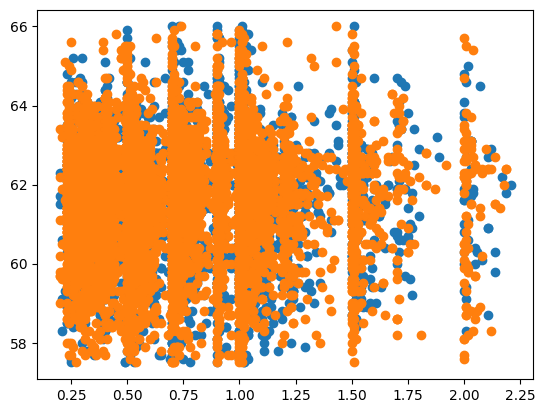

In [11]:
df_0 = df_train.loc[df['features/color'] == 0]
df_1 = df_train.loc[df['features/color'] == 1]
plt.scatter(df_0['features/carat'], df_0['features/depth'])
plt.scatter(df_1['features/carat'], df_1['features/depth'])

Видно, что точки двух классов находятся примерно в одном месте. Будет сложно обучить модель разделять эти классы, выделить маленькую часть датасета также не получилось, точки разных классов так же пересекаются, так что будем работать с тем, что есть.

Разделим признаки и метку на тренировочную и тестовую выборки, создадим нормализующий слой

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df_gen[['features/carat', 'features/depth']], df_gen['features/color'], test_size=0.3, random_state=1)
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(x_train)

Зададим функцию для расчета Показателя бинарной классификации

In [13]:
def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))

Постарался задать такое количество эпох и такой lr, чтобы по возможности избежать переобучения каждой модели

Создадим первую модель и обучим

In [14]:
model_1 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [15]:
model_1.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.Adamax(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [16]:
history1 = model_1.fit(
    x_train, y_train,
    epochs=80,
    verbose=1,
    validation_split = 0.2)

Epoch 1/80
925/925 [==============================] - 3s 2ms/step - loss: 0.6715 - accuracy: 0.5817 - val_loss: 0.6696 - val_accuracy: 0.5922
Epoch 2/80
925/925 [==============================] - 1s 2ms/step - loss: 0.6695 - accuracy: 0.5835 - val_loss: 0.6640 - val_accuracy: 0.5902
Epoch 3/80
925/925 [==============================] - 1s 2ms/step - loss: 0.6696 - accuracy: 0.5834 - val_loss: 0.6652 - val_accuracy: 0.5900
Epoch 4/80
925/925 [==============================] - 1s 2ms/step - loss: 0.6686 - accuracy: 0.5833 - val_loss: 0.6629 - val_accuracy: 0.5943
Epoch 5/80
925/925 [==============================] - 1s 2ms/step - loss: 0.6683 - accuracy: 0.5841 - val_loss: 0.6622 - val_accuracy: 0.5915
Epoch 6/80
925/925 [==============================] - 1s 2ms/step - loss: 0.6683 - accuracy: 0.5805 - val_loss: 0.6625 - val_accuracy: 0.5925
Epoch 7/80
925/925 [==============================] - 1s 2ms/step - loss: 0.6684 - accuracy: 0.5843 - val_loss: 0.6655 - val_accuracy: 0.5983
Epoch 

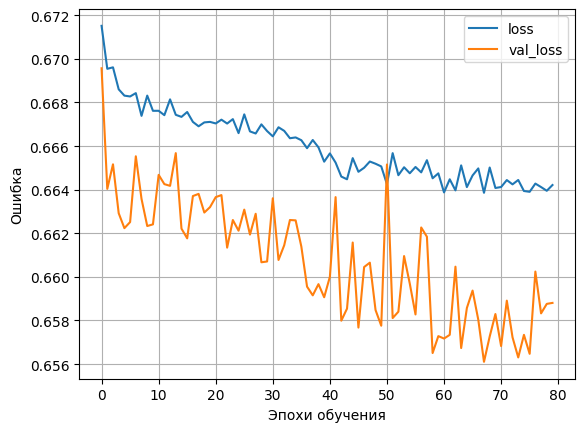

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(True)
plot_loss(history1)

Создадим вторую модель и обучим

In [18]:
model_2 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation = 'swish'),
    tf.keras.layers.Dense(64, activation = 'swish'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'swish'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'swish'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.Adamax(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [19]:
history2 = model_2.fit(
    x_train, y_train,
    epochs=60,
    verbose=1,
    validation_split = 0.2)

Epoch 1/60
925/925 [==============================] - 3s 2ms/step - loss: 0.6714 - accuracy: 0.5798 - val_loss: 0.6660 - val_accuracy: 0.5876
Epoch 2/60
925/925 [==============================] - 2s 2ms/step - loss: 0.6698 - accuracy: 0.5829 - val_loss: 0.6654 - val_accuracy: 0.5830
Epoch 3/60
925/925 [==============================] - 2s 2ms/step - loss: 0.6696 - accuracy: 0.5833 - val_loss: 0.6654 - val_accuracy: 0.5892
Epoch 4/60
925/925 [==============================] - 2s 2ms/step - loss: 0.6691 - accuracy: 0.5822 - val_loss: 0.6670 - val_accuracy: 0.5814
Epoch 5/60
925/925 [==============================] - 2s 2ms/step - loss: 0.6692 - accuracy: 0.5825 - val_loss: 0.6652 - val_accuracy: 0.5895
Epoch 6/60
925/925 [==============================] - 2s 2ms/step - loss: 0.6690 - accuracy: 0.5815 - val_loss: 0.6647 - val_accuracy: 0.5903
Epoch 7/60
925/925 [==============================] - 2s 2ms/step - loss: 0.6683 - accuracy: 0.5836 - val_loss: 0.6659 - val_accuracy: 0.5908
Epoch 

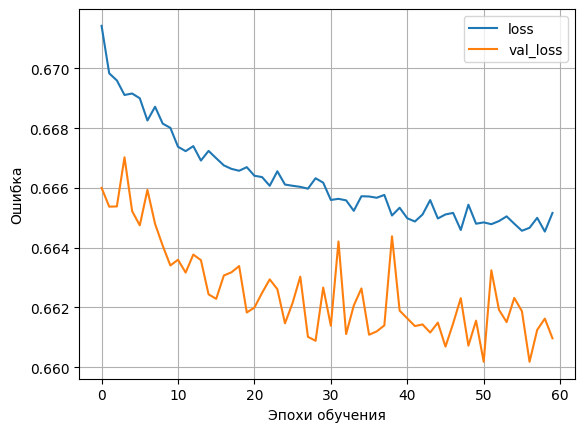

In [20]:
plot_loss(history2)

Создадим третью модель и обучим

In [21]:
model_3 = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'tanh'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model_3.compile(
    loss = 'binary_crossentropy',
    optimizer=tf.optimizers.Adamax(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [22]:
history3 = model_3.fit(
    x_train, y_train,
    epochs=50,
    verbose=1,
    validation_split = 0.2)

Epoch 1/50
925/925 [==============================] - 3s 2ms/step - loss: 0.6754 - accuracy: 0.5751 - val_loss: 0.6696 - val_accuracy: 0.5749
Epoch 2/50
925/925 [==============================] - 2s 2ms/step - loss: 0.6734 - accuracy: 0.5738 - val_loss: 0.6687 - val_accuracy: 0.5799
Epoch 3/50
925/925 [==============================] - 2s 2ms/step - loss: 0.6723 - accuracy: 0.5773 - val_loss: 0.6683 - val_accuracy: 0.5807
Epoch 4/50
925/925 [==============================] - 2s 2ms/step - loss: 0.6714 - accuracy: 0.5777 - val_loss: 0.6662 - val_accuracy: 0.5891
Epoch 5/50
925/925 [==============================] - 2s 2ms/step - loss: 0.6700 - accuracy: 0.5820 - val_loss: 0.6630 - val_accuracy: 0.5887
Epoch 6/50
925/925 [==============================] - 2s 2ms/step - loss: 0.6683 - accuracy: 0.5834 - val_loss: 0.6631 - val_accuracy: 0.5927
Epoch 7/50
925/925 [==============================] - 2s 2ms/step - loss: 0.6681 - accuracy: 0.5810 - val_loss: 0.6635 - val_accuracy: 0.5892
Epoch 

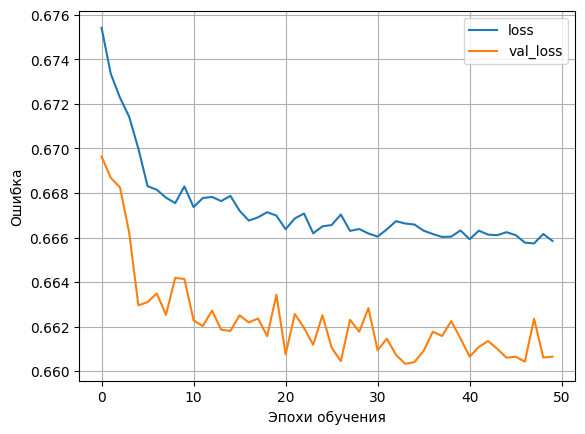

In [23]:
plot_loss(history3)

Сравним эффективность моделей по показателю бинарной классификации TP

In [24]:
y_prediction1 = model_1.predict(x_train)
y_pred1 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(y_prediction1)])
y_prediction2 = model_2.predict(x_train)
y_pred2 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(y_prediction2)])
y_prediction3 = model_3.predict(x_train)
y_pred3 = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(y_prediction3)])
#TP(y_pred1, y_train)
TP(y_pred1, np.array(y_train)), TP(y_pred2, np.array(y_train)), TP(y_pred3, np.array(y_train))

1156/1156 [==============================] - 1s 887us/step


(10219, 7806, 7698)

Лучший результат показала первая модель(model_1)

 ### Задание 5. Визуализируйте границы принятия решений построенных нейронных сетей на отдельных рисунках на всем наборе данных из двух признаков и бинарных меток классов.

### Решение
Зададим функцию построения графика границы принятия решений

In [25]:
def plot_decision_boundary(model, X, y):
    # Найдем диапазоны изменения по осям и построим сетку
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Набор данных для прогнозирования
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # Прогноз при помощи обученной модели
    y_pred = model.predict(X_in)
    # Проверка мультиклассовости
    if len(y_pred[1]) > 1:
        # мультиклассовая классификация
        # изменяем форму прогноза для визуализации
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        # бинарная классификация
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Рисуем границу решения
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 0s 901us/step


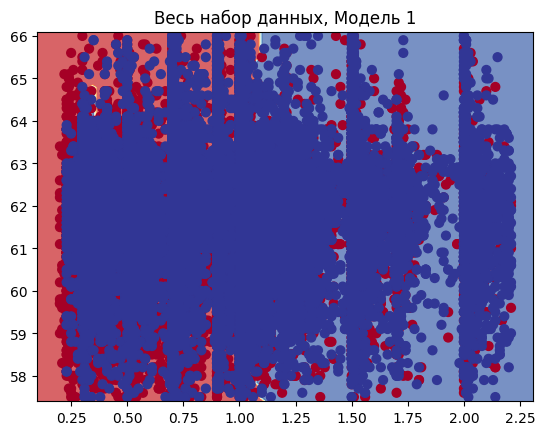

In [26]:
plt.title("Весь набор данных, Модель 1")
X = np.array(df_gen[['features/carat', 'features/depth']])
y=df_gen['features/color']
plot_decision_boundary(model_1, X=X, y=y)

313/313 [==============================] - 0s 918us/step


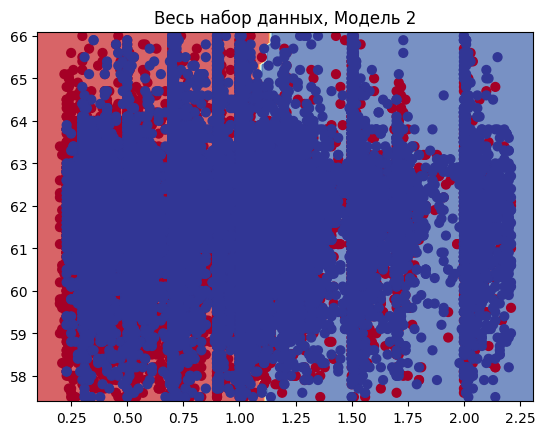

In [27]:
plt.title("Весь набор данных, Модель 2")
plot_decision_boundary(model_2, X=X, y=y)

313/313 [==============================] - 0s 887us/step


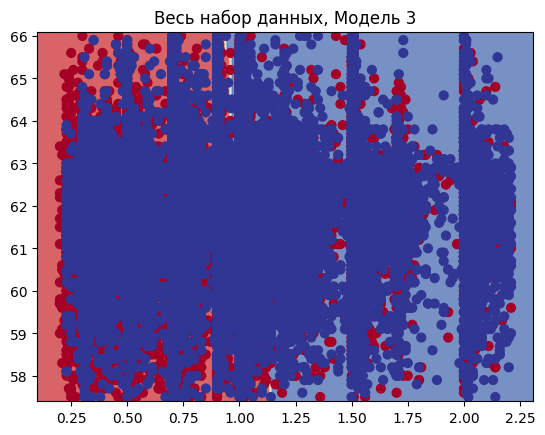

In [28]:
plt.title("Весь набор данных, Модель 3")
plot_decision_boundary(model_3, X=X, y=y)

### Задание 6. Визуализируйте на одном рисунке ROC-кривые для построенных классификаторов на основе нейронных сетей, вычислите площади под ROC-кривыми методом трапеций или иным методом и создайте легенду с указанием площадей кривых.

### Решение
Зададим необходимые функции

In [29]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [30]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):

        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])

    return roc.reshape(-1, 2)

Построим график и выведем в легенде площадь под соответствующей кривой ROC

1652/1652 [==============================] - 1s 867us/step


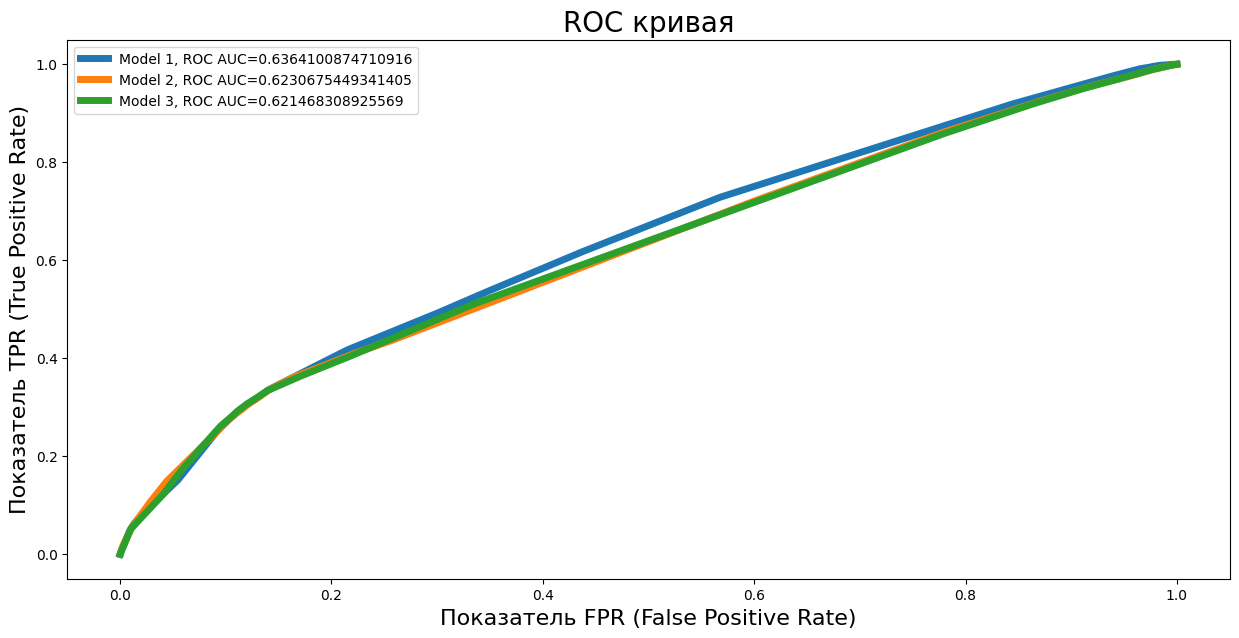

In [31]:
plt.figure(figsize=(15,7))
m1 = model_1.predict(X)
m2 = model_2.predict(X)
m3 = model_3.predict(X)
r1 = roc_auc_score(y, m1)
r2 = roc_auc_score(y, m2)
r3 = roc_auc_score(y, m3)
ROC1 = roc_from_scratch(m1.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC1[:,0],ROC1[:,1],lw=5, label='Model 1, ROC AUC=' + str(r1))
ROC2 = roc_from_scratch(m2.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC2[:,0],ROC2[:,1],lw=5, label='Model 2, ROC AUC=' + str(r2))
ROC3 = roc_from_scratch(m3.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC3[:,0],ROC3[:,1],lw=5, label='Model 3, ROC AUC=' + str(r3))
plt.title('ROC кривая',fontsize=20)
plt.xlabel('Показатель FPR (False Positive Rate)',fontsize=16)
plt.ylabel('Показатель TPR (True Positive Rate)',fontsize=16)
plt.legend();

Самый большой показатель у первой модели

### Задание 7. Определите исходном наборе данных дополнительный признак, отличный от указанных в задании двух независимых признаков, принимающий непрерывные значения и имеющий максимальную дисперсию.

Посчитаем стандартное отклонение всех признаков кроме независимых и метки

In [32]:
df_std = df_gen[['features/clarity','features/cut','features/table','features/x','features/y','features/z','price']].std()

In [33]:
df_std

features/clarity       1.641569
features/cut           1.080837
features/table         2.191895
features/x             1.094890
features/y             1.117625
features/z             0.688114
price               3870.685303
dtype: float64

Самый большой показатель у метки 'price'

### Задание 8. Визуализируйте точки набора данных в трехмерном пространстве с координатами, соответствующими трем независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

### Решение
Построим 3D-график, визуализирую точки набора данных и отмечая разные классы разным цветом

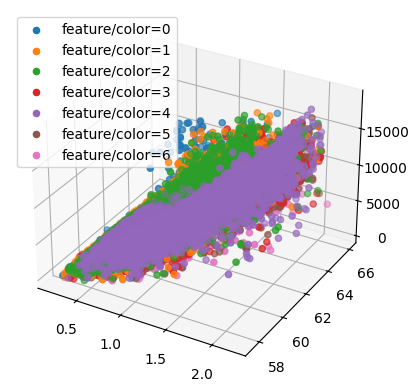

In [34]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(7):
    df_tmp = df.loc[df['features/color'] == i]
    ax.scatter(df_tmp['features/carat'], df_tmp['features/depth'], df_tmp['price'],  label='feature/color=' + str(i))
ax.legend();

### Задание 9. Разбейте исходный набор данных на обучающую и тестовую выборки. Постройте нейронную сеть для многоклассовой классификации с нормализующим слоем и параметрами, соответствующими лучшей нейронной сети для бинарной классифиации из п.4, и обучите ее на обучающей выборке, контролируя процесс ее обучения.

### Решение
Сделаем метку one-hot encoded и разделим независимые признаки и метку на обучающую и тестовую выборки 

In [35]:
X = df[['features/carat', 'features/depth', 'price']]
Y = list(df['features/color'])
for i in range(len(Y)):
    tmp = [0]*7
    tmp[Y[i]] = 1
    Y[i] = tmp
Y = np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

Так как лучший результат показала первая модель, используем её как основу, изменим последний слой, чтобы он соответствовал нашей задаче мультиклассовой классификации, также изменим функцию потерь.

In [36]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

model_final = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'leaky_relu'),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
model_final.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.optimizers.Adamax(learning_rate=0.001)
)

Количество эпох подобрал так, чтобы модель останавливалась перед переобучением / в его начале

In [37]:
history = model_final.fit(X_train, Y_train, epochs=125, verbose=1, validation_split = 0.3)

Epoch 1/125
810/810 [==============================] - 3s 2ms/step - loss: 1.8255 - val_loss: 1.7756
Epoch 2/125
810/810 [==============================] - 1s 2ms/step - loss: 1.7572 - val_loss: 1.7378
Epoch 3/125
810/810 [==============================] - 1s 2ms/step - loss: 1.7278 - val_loss: 1.7199
Epoch 4/125
810/810 [==============================] - 1s 2ms/step - loss: 1.7147 - val_loss: 1.7089
Epoch 5/125
810/810 [==============================] - 1s 2ms/step - loss: 1.7087 - val_loss: 1.7035
Epoch 6/125
810/810 [==============================] - 1s 2ms/step - loss: 1.7038 - val_loss: 1.7062
Epoch 7/125
810/810 [==============================] - 1s 2ms/step - loss: 1.6990 - val_loss: 1.6933
Epoch 8/125
810/810 [==============================] - 1s 2ms/step - loss: 1.6962 - val_loss: 1.6906
Epoch 9/125
810/810 [==============================] - 1s 2ms/step - loss: 1.6950 - val_loss: 1.6883
Epoch 10/125
810/810 [==============================] - 1s 2ms/step - loss: 1.6923 - val_lo

### Задание 10. Постройте кривые обучения в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

### Решение

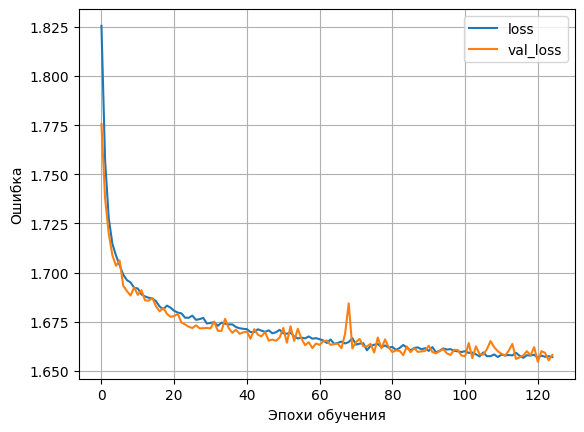

In [38]:
plot_loss(history)